In [28]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
import sys

sys.path.insert(0,  '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, plot_performance, score2
from compass.tokenizer import CANCER_CODE, CONCEPT_palette
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [29]:
df_label1 = pd.read_pickle('PAIRED_PD1_CTLA4_PRE_SMPLE.TABLE')
df_tpm1 = pd.read_pickle('PAIRED_PD1_CTLA4_PRE_TPM.TABLE')
dfcx1 = df_label1.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm1)


In [30]:
df_label2 = pd.read_pickle('PAIRED_PD1_CTLA4_POST_SMPLE.TABLE')
df_tpm2 = pd.read_pickle('PAIRED_PD1_CTLA4_POST_TPM.TABLE')
dfcx2 = df_label2.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm2)


In [31]:
save_dir = '/home/was966/Research/mims-compass/paper/'
pretrainer = loadcompass(os.path.join(save_dir, 'checkpoint/latest/pretrainer.pt'), map_location = 'cpu')

In [32]:
dfg1, dfe1 = pretrainer.extract(dfcx1)

100%|##########| 1/1 [00:03<00:00,  3.11s/it]


In [33]:
dfg2, dfe2 = pretrainer.extract(dfcx2)

100%|##########| 1/1 [00:03<00:00,  3.12s/it]


In [34]:
dfe1.join(df_label1.response_label).to_excel('./results/pre_treatment_concept.xlsx')
dfe2.join(df_label2.response_label).to_excel('./results/post_treatment_concept.xlsx')

In [35]:
res = []
for col in dfe1.columns:
    df1 = dfe1[col].to_frame(name=  'values')
    df1['concept'] =  col
    df1['group'] = 'Pre'
    df1['response_label'] = df_label1['response_label']

    df2 = dfe2[col].to_frame(name=  'values')
    df2['concept'] =  col
    df2['group'] = 'Post'
    df2['response_label'] = df_label2['response_label']

    df = df1._append(df2)

    min = df['values'].min()
    max = df['values'].max()
    mean = df['values'].mean()
    std = df['values'].std()

    ## z-score standard
    df['values'] = (df['values'] - mean) / std
    res.append(df)

In [36]:
from scipy.stats import ttest_rel
df = pd.concat(res)
df.to_csv('./results/source_data_for_dynamic_changes.csv')

p = df.groupby(['concept']).apply(lambda x:ttest_rel(x[x['group'] == 'Pre']['values'], 
                                                                  x[x['group'] == 'Post']['values'])[1]).sort_values()

def fold(x1, x2):
    return abs(x1.median() - x2.median())
fc = df.groupby(['concept']).apply(lambda x:fold(x[x['group'] == 'Pre']['values'], 
                                                                  x[x['group'] == 'Post']['values'])).sort_values(ascending=False)
fc

concept
IFNg_pathway            0.778239
Cytotoxic_Tcell         0.752490
Immune_checkpoint       0.587933
Treg                    0.519514
Exhausted_Tcell         0.496299
Mesothelial             0.464086
Plasma_cell             0.441605
Memory_Tcell            0.376203
Memory_Bcell            0.353278
Tcell_general           0.297745
Pancreatic              0.291356
Apoptosis_pathway       0.274778
Innate_lymphoid_cell    0.265630
Mast                    0.265040
Stroma                  0.234660
Cell_proliferation      0.220356
NKcell                  0.161399
Myeloid                 0.142056
Pericyte                0.141772
Pneumocyte              0.140241
Genome_integrity        0.140127
Adipocyte               0.138005
CD8_Tcell               0.115944
Bcell_general           0.103592
Macrophage              0.095733
Platelet                0.085629
Naive_Tcell             0.074936
Cytokine                0.072275
Endothelial             0.065638
Stem                    0.062455
cD

In [37]:
fc.index

Index(['IFNg_pathway', 'Cytotoxic_Tcell', 'Immune_checkpoint', 'Treg',
       'Exhausted_Tcell', 'Mesothelial', 'Plasma_cell', 'Memory_Tcell',
       'Memory_Bcell', 'Tcell_general', 'Pancreatic', 'Apoptosis_pathway',
       'Innate_lymphoid_cell', 'Mast', 'Stroma', 'Cell_proliferation',
       'NKcell', 'Myeloid', 'Pericyte', 'Pneumocyte', 'Genome_integrity',
       'Adipocyte', 'CD8_Tcell', 'Bcell_general', 'Macrophage', 'Platelet',
       'Naive_Tcell', 'Cytokine', 'Endothelial', 'Stem', 'cDC', 'Hepatocyte',
       'pDC', 'Monocyte', 'Epithelial', 'Fibroblast', 'TGFb_pathway', 'CANCER',
       'Reference', 'TLS', 'Granulocyte', 'Erythrocyte', 'Naive_Bcell',
       'CD4_Tcell'],
      dtype='object', name='concept')

In [38]:
dfr = df[df.response_label == 'NR']
x1 = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Pre'].sort_values(ascending=False)
x2 = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Post'].sort_values(ascending=False)

concept_used = []
concept_used.extend(x1.head(5).index)
concept_used.extend(x1.head(5).index)
concept_used.extend(x2.tail(5).index)
concept_used.extend(x2.tail(5).index)
concept_used = list(set(concept_used))

dfr = df[df.response_label == 'R']
x1 = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Pre'].sort_values(ascending=False)
x2 = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Post'].sort_values(ascending=False)

concept_used.extend(x1.head(5).index)
concept_used.extend(x1.head(5).index)
concept_used.extend(x2.tail(5).index)
concept_used.extend(x2.tail(5).index)
concept_used = list(set(concept_used))
concept_used

['Naive_Tcell',
 'Plasma_cell',
 'TLS',
 'Immune_checkpoint',
 'Innate_lymphoid_cell',
 'Treg',
 'Bcell_general',
 'Myeloid',
 'NKcell',
 'Genome_integrity',
 'Exhausted_Tcell',
 'CD8_Tcell',
 'Platelet',
 'pDC']

In [39]:
concept_used = fc.index[:20].tolist() #p[p < 0.05].index.to_list()
concept_used.append('Reference')

In [40]:
fc

concept
IFNg_pathway            0.778239
Cytotoxic_Tcell         0.752490
Immune_checkpoint       0.587933
Treg                    0.519514
Exhausted_Tcell         0.496299
Mesothelial             0.464086
Plasma_cell             0.441605
Memory_Tcell            0.376203
Memory_Bcell            0.353278
Tcell_general           0.297745
Pancreatic              0.291356
Apoptosis_pathway       0.274778
Innate_lymphoid_cell    0.265630
Mast                    0.265040
Stroma                  0.234660
Cell_proliferation      0.220356
NKcell                  0.161399
Myeloid                 0.142056
Pericyte                0.141772
Pneumocyte              0.140241
Genome_integrity        0.140127
Adipocyte               0.138005
CD8_Tcell               0.115944
Bcell_general           0.103592
Macrophage              0.095733
Platelet                0.085629
Naive_Tcell             0.074936
Cytokine                0.072275
Endothelial             0.065638
Stem                    0.062455
cD

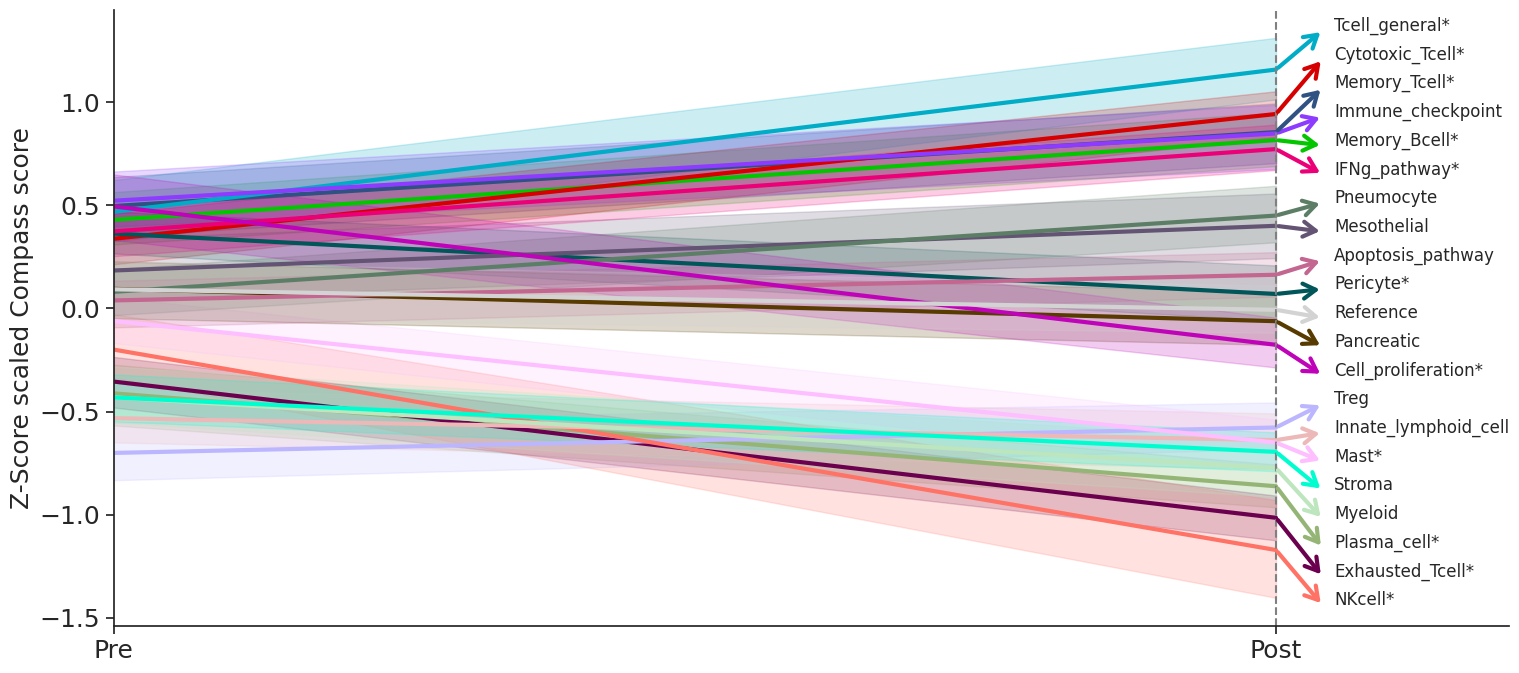

In [41]:
fig, ax = plt.subplots(figsize=(18, 8))

dfr = df[df.response_label == 'R']
dfr = dfr[dfr.concept.isin(concept_used)]
sns.lineplot(data = dfr, x = 'group', y = 'values', hue = 'concept',  lw = 3, alpha = 1, 
             palette=CONCEPT_palette, ax=ax,  errorbar=('ci', 50), legend=False)

y = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Post'].sort_values(ascending=True)
vmin, vmax = ax.get_ylim()

ay = np.linspace(vmin+0.1, vmax-0.1, len(y))


p_group = dfr.groupby(['concept']).apply(lambda x:ttest_rel(x[x['group'] == 'Pre']['values'], 
                                                                  x[x['group'] == 'Post']['values'])[1]).sort_values()
sig_concept = p_group[p_group < 0.05].index


for i in range(len(y)):
    ts = y.iloc[i]
    v = y.index[i]
    color = CONCEPT_palette[v]

    if v in sig_concept:
        v = v + '*'
        
    ax.text(1.05, ay[i], v, fontsize=12, )    #color = color
    ax.annotate("", xy=(1, y.iloc[i]), xytext=(1.04, ay[i]), arrowprops=dict(arrowstyle="<-, head_width=0.3, head_length=0.5",lw=3, color =color )) # color=feature_color, 
    #ax.annotate("", xy=(1, y.iloc[i]), xytext=(1.05, ay[i]), arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5",lw=1.5, color =color )) # color=feature_color, 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(None)
ax.set_xlim(0.,1.2)
ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=18)

ax.axvline(x=1, color='grey', linestyle='--')

ax.set_ylabel('Z-Score scaled Compass score')

fig.savefig("./results/02_pre_post_dynamic_responder.svg"  , bbox_inches = 'tight')

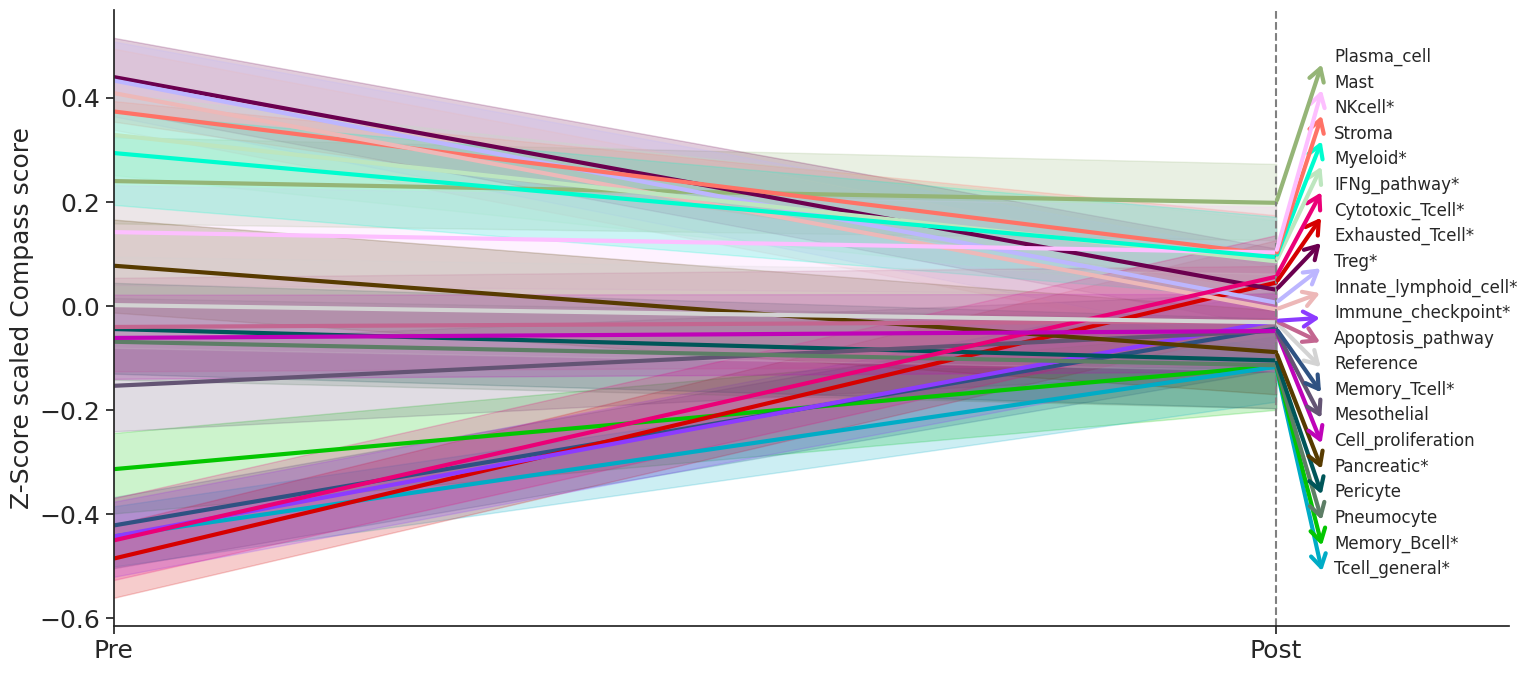

In [42]:
fig, ax = plt.subplots(figsize=(18, 8))

dfr = df[df.response_label == 'NR']
dfr = dfr[dfr.concept.isin(concept_used)]
sns.lineplot(data = dfr, x = 'group', y = 'values', hue = 'concept',  lw = 3, alpha = 1, 
             palette=CONCEPT_palette, ax=ax,  errorbar=('ci', 50), legend=False)

y = dfr.groupby(['concept', 'group',])['values'].mean().unstack()['Post'].sort_values(ascending=True)
vmin, vmax = ax.get_ylim()

ay = np.linspace(vmin+0.1, vmax-0.1, len(y))


p_group = dfr.groupby(['concept']).apply(lambda x:ttest_rel(x[x['group'] == 'Pre']['values'], 
                                                                  x[x['group'] == 'Post']['values'])[1]).sort_values()
sig_concept = p_group[p_group < 0.05].index


for i in range(len(y)):
    ts = y.iloc[i]
    v = y.index[i]
    color = CONCEPT_palette[v]


    if v in sig_concept:
        v = v + '*'
        
    ax.text(1.05, ay[i], v, fontsize=12, )    #color = color
    ax.annotate("", xy=(1, y.iloc[i]), xytext=(1.04, ay[i]), arrowprops=dict(arrowstyle="<-, head_width=0.3, head_length=0.5",lw=3, color =color )) # color=feature_color, 
    #ax.annotate("", xy=(1, y.iloc[i]), xytext=(1.05, ay[i]), arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5",lw=1.5, color =color )) # color=feature_color, 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(None)
ax.set_xlim(0.,1.2)
ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=18)

ax.axvline(x=1, color='grey', linestyle='--')

ax.set_ylabel('Z-Score scaled Compass score')
fig.savefig("./results/02_pre_post_dynamic_non-responder.svg"  , bbox_inches = 'tight')

In [43]:
from shap.plots import colors

Pre
(n=86) vs. Post
(n=86): t-test paired samples, P_val:5.522e-09 t=-6.488e+00
Pre
(n=86) vs. Post
(n=86): t-test paired samples, P_val:7.739e-09 t=6.411e+00
Pre
(n=86) vs. Post
(n=86): t-test paired samples, P_val:4.718e-01 t=7.228e-01


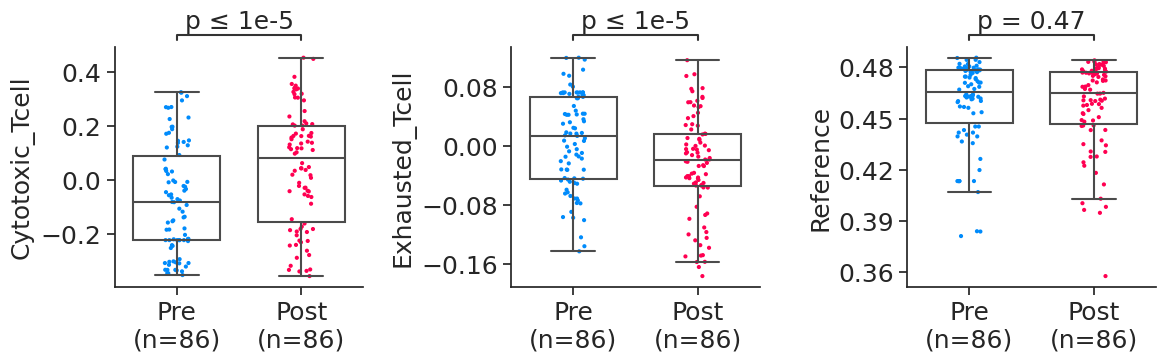

In [44]:
response_order = ['Pre', 'Post']
cm = sns.color_palette("Paired", 10)
palette =  [colors.blue_rgb,colors.red_rgb] #[bright[-2], bright[-1]]


fig, axes = plt.subplots(figsize=(12,4), nrows = 1, ncols = 3, sharex=False, sharey = False)

import matplotlib.ticker as ticker
import scipy
from statannotations.Annotator import Annotator

source_data = []
for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell
    
    df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
    df1['group'] = 'Pre'
    df1['response_label'] = df_label1.response_label
    #df1['patient_id'] = df_label1.patient_id

    df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)


    
    df2 = dfe2[[c]]
    df2['group'] = 'Post'  
    df2['response_label'] = df_label2.response_label
    #df2['patient_id'] = df_label2.patient_id
    
    df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)



    df = df1._append(df2)

    x = 'group'
    
    dfp = df

    
    size = dfp.groupby(x).size()
    size = size.index + "\n(n=" + size.astype(str) + ')'
    response_map = size.to_dict()
    dfp[x] = dfp[x].map(response_map)



    source_data.append(dfp)
    
    x_order = dfp.groupby(x).size().sort_index(ascending=False).index.tolist()
    
    sns.boxplot(data = dfp, x = x, y = c, order =x_order,
                ax=ax, width = .7, fliersize=0, palette = palette, boxprops={'facecolor':'None'}, saturation=1) #palette = palette, 
    sns.stripplot(data = dfp, x = x, y = c, order =x_order,zorder = 0.5,size=3,linewidth = 0.00,
                ax=ax, palette = palette) #palette = palette, boxprops={'facecolor':'None'}
    # if v == 'Reference':
    #     ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    # if c == 'Average':
    #     ax.set_ylabel(v)
    # else:
    #     ax.set_ylabel(None)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=18)
    
    
    box_pairs = [x_order]
    annotator = Annotator(ax, pairs=box_pairs, data=dfp, x=x, y=c, order=x_order)
    annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,
                        #pvalue_format = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]],
                        comparisons_correction = None,)
    annotator.apply_and_annotate()

    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

fig.tight_layout()
fig.savefig("./results/03_pre_post_boxplot_feature.svg"  , bbox_inches = 'tight')

In [45]:
pd.concat(source_data)

,Cytotoxic_Tcell,group,response_label,patient_id,Exhausted_Tcell,Reference
107T@0,-0.220722,Pre\n(n=86),NR,107T@0,NaN,NaN
10_PD1@1,-0.227360,Pre\n(n=86),NR,10_PD1@1,NaN,NaN
115T@2,-0.118139,Pre\n(n=86),NR,115T@2,NaN,NaN
13_PD1@3,-0.309913,Pre\n(n=86),NR,13_PD1@3,NaN,NaN
13_ipiPD1@4,0.267402,Pre\n(n=86),R,13_ipiPD1@4,NaN,NaN
...,...,...,...,...,...,...
Pt89@81,NaN,Post\n(n=86),NR,Pt89@81,NaN,0.478005
Pt9@82,NaN,Post\n(n=86),NR,Pt9@82,NaN,0.483235
Pt92@83,NaN,Post\n(n=86),NR,Pt92@83,NaN,0.472918
Pt94@84,NaN,Post\n(n=86),R,Pt94@84,NaN,0.468640


In [46]:
dfp

,Reference,group,response_label,patient_id
107T@0,0.440586,Pre\n(n=86),NR,107T@0
10_PD1@1,0.463355,Pre\n(n=86),NR,10_PD1@1
115T@2,0.435595,Pre\n(n=86),NR,115T@2
13_PD1@3,0.460246,Pre\n(n=86),NR,13_PD1@3
13_ipiPD1@4,0.464140,Pre\n(n=86),R,13_ipiPD1@4
...,...,...,...,...
Pt89@81,0.478005,Post\n(n=86),NR,Pt89@81
Pt9@82,0.483235,Post\n(n=86),NR,Pt9@82
Pt92@83,0.472918,Post\n(n=86),NR,Pt92@83
Pt94@84,0.468640,Post\n(n=86),R,Pt94@84


In [47]:
cs = sns.palettes.color_palette('Spectral_r', 6).as_hex()
cs

['#47a0b3', '#a2d9a4', '#edf8a3', '#fee999', '#fca55d', '#e2514a']

In [48]:
c1 = [cs[0],cs[1]]
c2 = [cs[2],cs[3]]

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.459e-06 U_stat=1.152e+03
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.619e-04 U_stat=1.038e+03
Pre vs. Post: t-test paired samples, P_val:7.739e-09 t=6.411e+00
155T@5 -0.028135296
212T@11 -0.005288817
43T@36 -0.07983416
98T@42 -0.028226279
Pt103@46 -0.05126202
Pt11@48 -0.027307704
Pt1@43 -0.04487495
Pt26@53 -0.02345688
Pt27@54 -0.017809365
Pt2@51 -0.011032622
Pt46@65 -0.019415615
Pt5@69 -0.0014299452
Pt67@73 -0.004934013
Pt8@77 -0.00521998
Pt9@82 -0.017967321
Pre
(n=64) vs. Post
(n=64): t-test paired samples, P_val:6.481e-06 t=4.922e+00
272T@13 -0.03280776
47_PD1@37 -0.00070051476
Pt44@64 -0.009906039
Pt48@67 -0.008290753
Pre
(n=22) vs. Post
(n=22): t-test paired samples, P_val:3.274e-04 t=4.287e+00


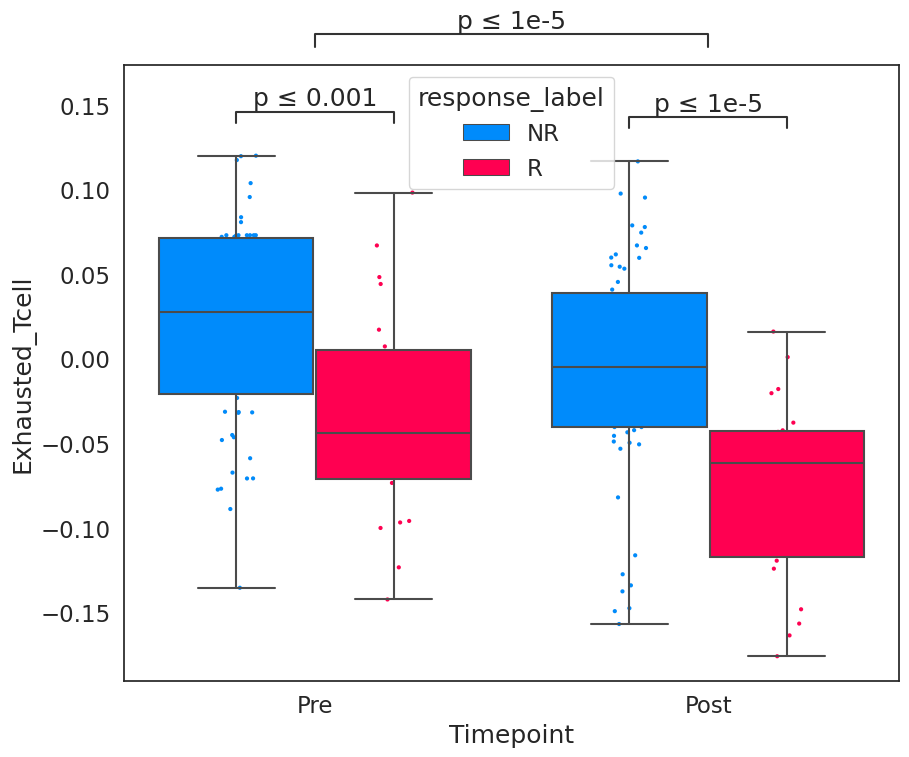

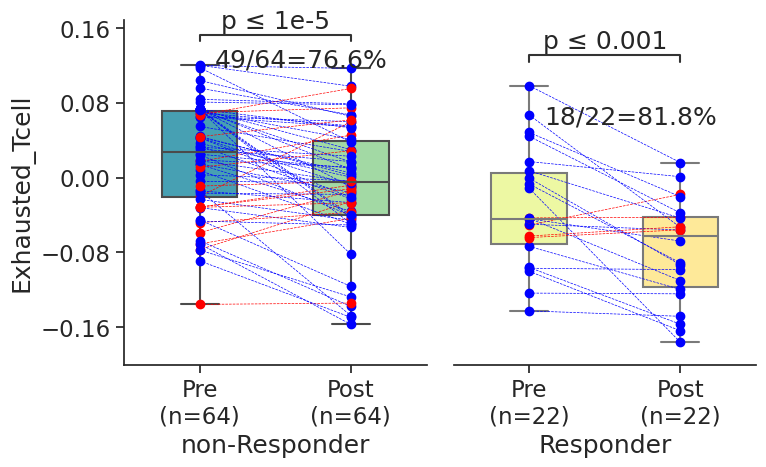

In [49]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Exhausted_Tcell'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(10, 8),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5,size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False,) #palette = palette ,boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values
    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = color,  linewidth = None, saturation= 1, ) #boxprops={'facecolor':'None'},
    
    ax.set_ylim(-0.2, 0.16)
    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'blue' if y[1] < y[0] else 'red'
        
        ax.plot(x, y, marker='o', color=color, lw = .5, ls = '--'  )
        if  y[1] > y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)
    
    ax.text(0.1, data[order].max().mean(), text)
    
    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.459e-06 U_stat=1.152e+03
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.619e-04 U_stat=1.038e+03
Pre vs. Post: t-test paired samples, P_val:7.739e-09 t=6.411e+00
155T@5 -0.028135296
212T@11 -0.005288817
43T@36 -0.07983416
98T@42 -0.028226279
Pt103@46 -0.05126202
Pt11@48 -0.027307704
Pt1@43 -0.04487495
Pt26@53 -0.02345688
Pt27@54 -0.017809365
Pt2@51 -0.011032622
Pt46@65 -0.019415615
Pt5@69 -0.0014299452
Pt67@73 -0.004934013
Pt8@77 -0.00521998
Pt9@82 -0.017967321
Pre
(n=64) vs. Post
(n=64): t-test paired samples, P_val:6.481e-06 t=4.922e+00
272T@13 -0.03280776
47_PD1@37 -0.00070051476
Pt44@64 -0.009906039
Pt48@67 -0.008290753
Pre
(n=22) vs. Post
(n=22): t-test paired samples, P_val:3.274e-04 t=4.287e+00


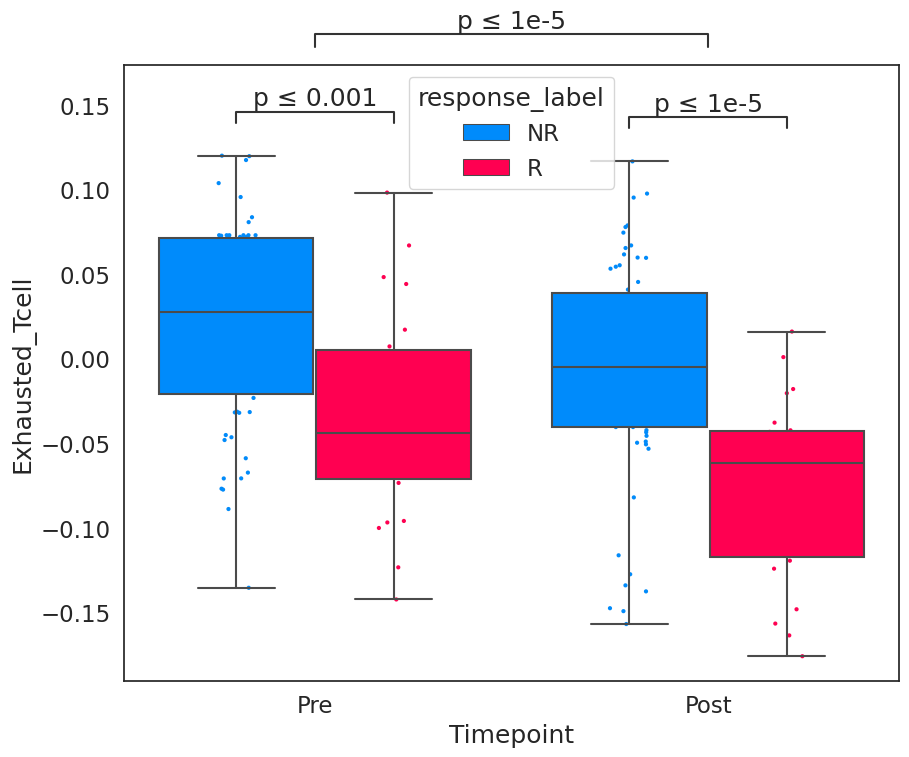

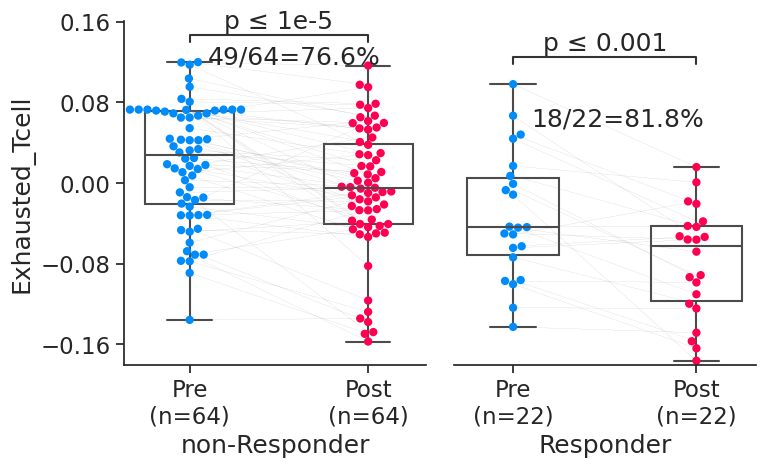

In [50]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Exhausted_Tcell'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(10, 8),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5, size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False,) #palette = palette ,boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values

    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'grey' if y[1] < y[0] else 'grey'
        
        ax.plot(x, y, marker=None, color=color, lw = .1, ls = '--' , markersize  = 3 )
        if  y[1] > y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)
    
    ax.text(0.1, data[order].max().mean(), text)

    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = palette,  saturation= 1, linewidth = None, boxprops={'facecolor':'None'}) #boxprops={'facecolor':'None'},boxprops={'facecolor':'None'}
    
    sns.swarmplot(data = data_long, x = 'Timepoint', y = c, zorder = 2,size=6,linewidth = 0.00,
                ax=ax, palette = palette) #palette = palette, boxprops={'facecolor':'None'}
    
    ax.set_ylim(-0.18, 0.16)

    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.090e-04 U_stat=3.390e+02
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:5.210e-04 U_stat=3.530e+02
Pre vs. Post: t-test paired samples, P_val:5.522e-09 t=-6.488e+00
107T@0 0.042367607
333T@18 0.05564593
379T@23 0.01647845
43T@36 0.23667791
62T@39 0.005814284
98T@42 0.0003042221
Pt103@46 0.33415186
Pt106@47 0.0055972114
Pt1@43 0.1937796
Pt26@53 0.08925042
Pt46@65 0.103495724
Pt47@66 0.0021094978
Pt52@70 0.006278839
Pt5@69 0.04908873
Pt67@73 0.056730732
Pt79@76 0.022640243
Pt84@79 0.011086464
Pre
(n=64) vs. Post
(n=64): t-test paired samples, P_val:7.081e-07 t=-5.510e+00
272T@13 0.06891672
Pt34@59 0.0662784
Pt44@64 0.096399695
Pt48@67 0.19165897
Pre
(n=22) vs. Post
(n=22): t-test paired samples, P_val:2.972e-03 t=-3.359e+00


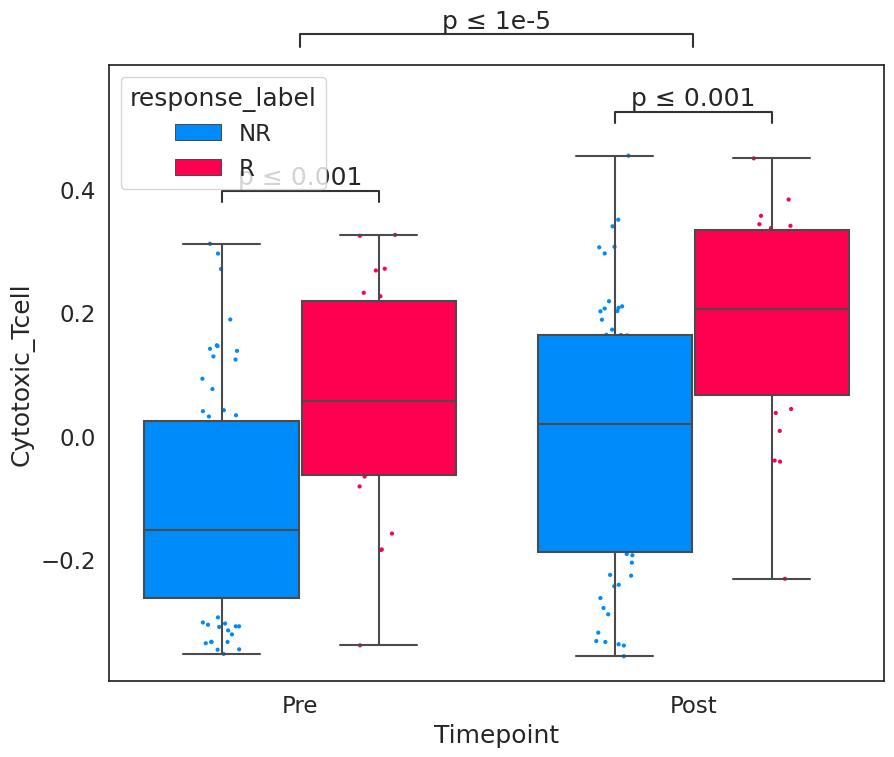

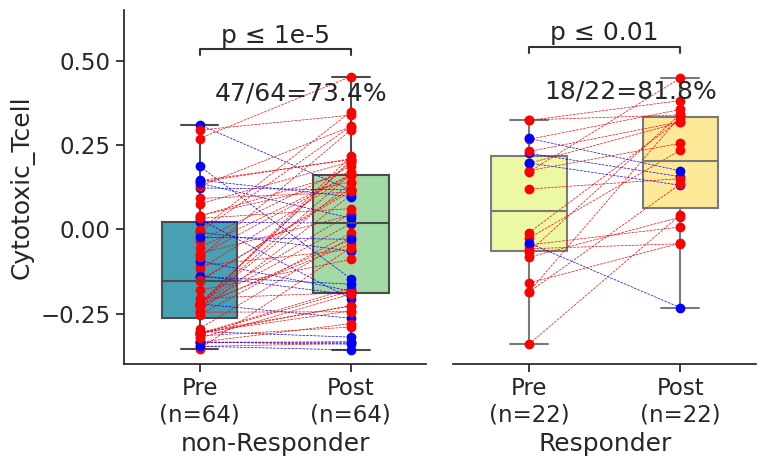

In [51]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Cytotoxic_Tcell'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(10, 8),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5,size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False) #palette = palette, boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values
    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = color,  saturation= 1, linewidth = None, ) #boxprops={'facecolor':'None'},boxprops={'facecolor':'None'}
    
    
    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'blue' if y[1] < y[0] else 'red'
        ax.plot(x, y, marker='o', color=color, lw = .5, ls = '--'  )
        if  y[1] < y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)
    
    ax.text(0.1, data[order].max().mean(), text)
    
    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.090e-04 U_stat=3.390e+02
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:5.210e-04 U_stat=3.530e+02
Pre vs. Post: t-test paired samples, P_val:5.522e-09 t=-6.488e+00
107T@0 0.042367607
333T@18 0.05564593
379T@23 0.01647845
43T@36 0.23667791
62T@39 0.005814284
98T@42 0.0003042221
Pt103@46 0.33415186
Pt106@47 0.0055972114
Pt1@43 0.1937796
Pt26@53 0.08925042
Pt46@65 0.103495724
Pt47@66 0.0021094978
Pt52@70 0.006278839
Pt5@69 0.04908873
Pt67@73 0.056730732
Pt79@76 0.022640243
Pt84@79 0.011086464
Pre
(n=64) vs. Post
(n=64): t-test paired samples, P_val:7.081e-07 t=-5.510e+00
272T@13 0.06891672
Pt34@59 0.0662784
Pt44@64 0.096399695
Pt48@67 0.19165897
Pre
(n=22) vs. Post
(n=22): t-test paired samples, P_val:2.972e-03 t=-3.359e+00


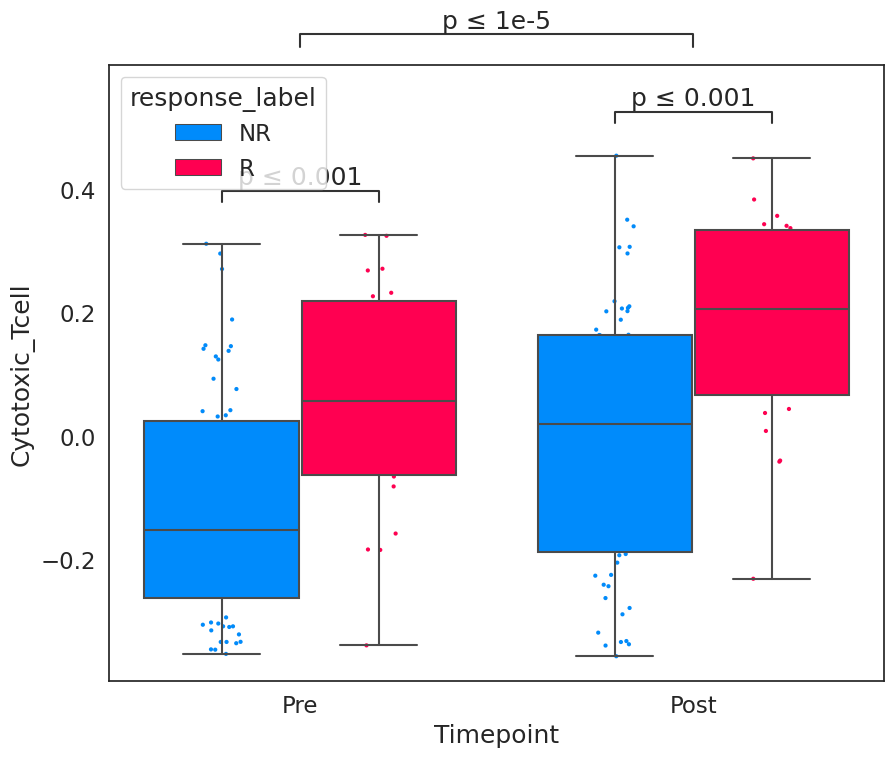

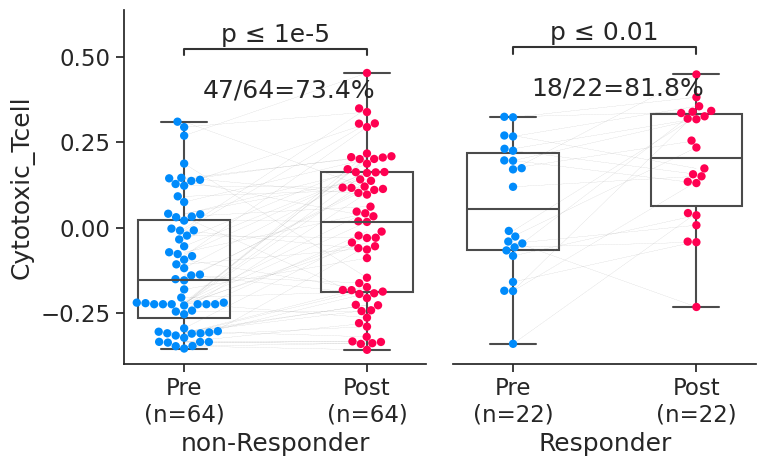

In [52]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Cytotoxic_Tcell'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(10, 8),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5,size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False) #palette = palette, boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values
    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'grey' if y[1] < y[0] else 'grey'
        ax.plot(x, y, marker=None, color=color, lw = .1, ls = '--'  )
        if  y[1] < y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)

    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = palette,  saturation= 1, linewidth = None, boxprops={'facecolor':'None'}) #boxprops={'facecolor':'None'},boxprops={'facecolor':'None'}
    
    sns.swarmplot(data = data_long, x = 'Timepoint', y = c, zorder = 2,size=6,linewidth = 0.00,
                ax=ax, palette = palette) #palette = palette, boxprops={'facecolor':'None'}

    
    ax.text(0.1, data[order].max().mean(), text)
    
    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.103e-01 U_stat=8.070e+02
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.172e-01 U_stat=7.150e+02
Pre vs. Post: t-test paired samples, P_val:4.718e-01 t=7.228e-01
10_PD1@1 0.0022592247
115T@2 0.007813513
155T@5 0.0125980675
17_PD1@6 0.01693654
19_ipiPD1@7 0.0023194253
212T@10 0.017413288
212T@11 0.043522
292T@16 0.02905047
333T@18 0.013054371
379T@23 0.008436143
383T@24 0.040095598
42T@33 0.02134943
42T@34 0.009072512
430T@35 0.026101172
43T@36 0.0021421313
62T@39 0.0020135045
8_PD1@41 0.026281625
98T@42 0.04286638
Pt106@47 0.0026533902
Pt10@44 0.00032004714
Pt11@48 0.004796803
Pt17@49 0.0023053586
Pt23@52 0.0021504164
Pt36@60 0.0022894442
Pt38@62 0.0011756122
Pt46@65 4.348159e-05
Pt4@63 0.008640915
Pt65@72 0.003017068
Pt67@73 0.0069540143
Pt77@74 0.0054166615
Pt78@75 0.0043412447
Pt79@76 0.0022003055
Pt82@78 0.0013620555
Pt85@80 0.0002964139
Pt98@85 0.000762105
Pre
(n=64) vs. Post
(n=64): t-test paired s

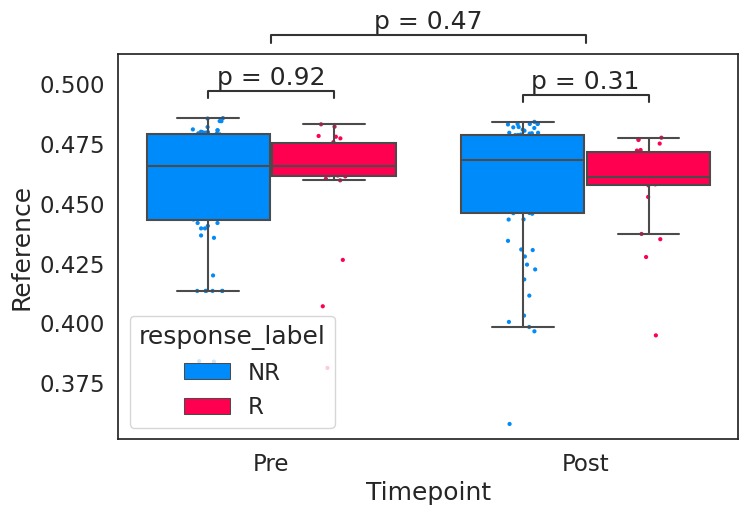

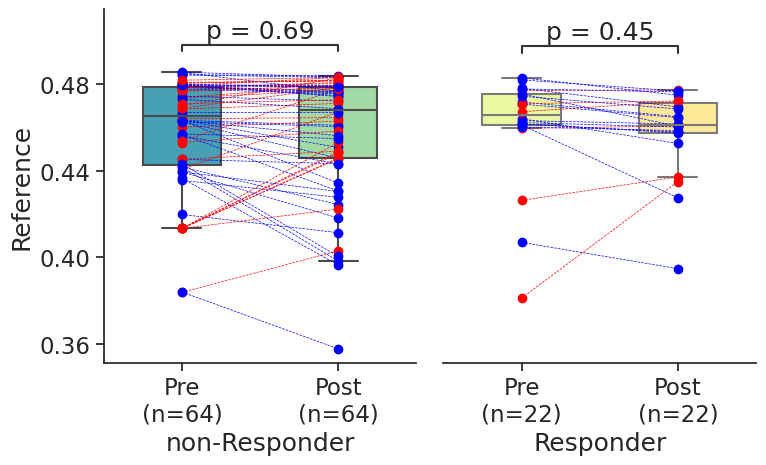

In [53]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Reference'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(8, 5),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5,size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False) #palette = palette, boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values
    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = color,  saturation= 1, linewidth = None) #boxprops={'facecolor':'None'},
    
    
    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'blue' if y[1] < y[0] else 'red'
        ax.plot(x, y, marker='o', color=color, lw = .5, ls = '--'  )
        if  y[1] < y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)
    
    #ax.text(0.1, data[order].max().mean(), text)
    
    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')

Post_NR vs. Post_R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.103e-01 U_stat=8.070e+02
Pre_NR vs. Pre_R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.172e-01 U_stat=7.150e+02
Pre vs. Post: t-test paired samples, P_val:4.718e-01 t=7.228e-01
10_PD1@1 0.0022592247
115T@2 0.007813513
155T@5 0.0125980675
17_PD1@6 0.01693654
19_ipiPD1@7 0.0023194253
212T@10 0.017413288
212T@11 0.043522
292T@16 0.02905047
333T@18 0.013054371
379T@23 0.008436143
383T@24 0.040095598
42T@33 0.02134943
42T@34 0.009072512
430T@35 0.026101172
43T@36 0.0021421313
62T@39 0.0020135045
8_PD1@41 0.026281625
98T@42 0.04286638
Pt106@47 0.0026533902
Pt10@44 0.00032004714
Pt11@48 0.004796803
Pt17@49 0.0023053586
Pt23@52 0.0021504164
Pt36@60 0.0022894442
Pt38@62 0.0011756122
Pt46@65 4.348159e-05
Pt4@63 0.008640915
Pt65@72 0.003017068
Pt67@73 0.0069540143
Pt77@74 0.0054166615
Pt78@75 0.0043412447
Pt79@76 0.0022003055
Pt82@78 0.0013620555
Pt85@80 0.0002964139
Pt98@85 0.000762105
Pre
(n=64) vs. Post
(n=64): t-test paired s

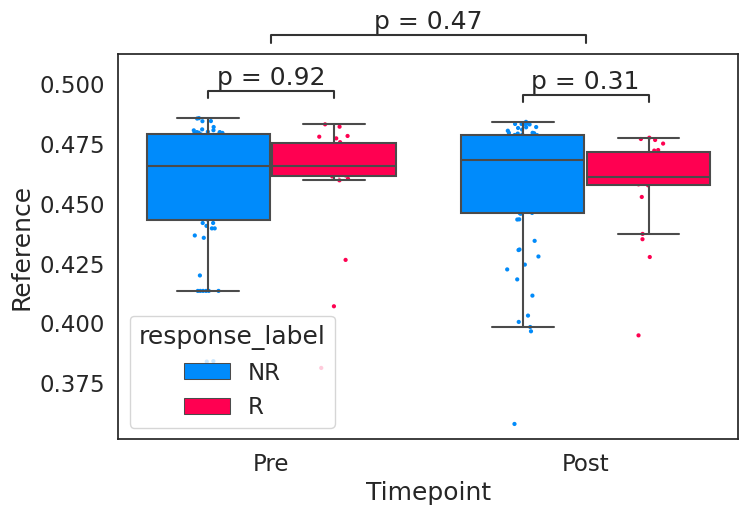

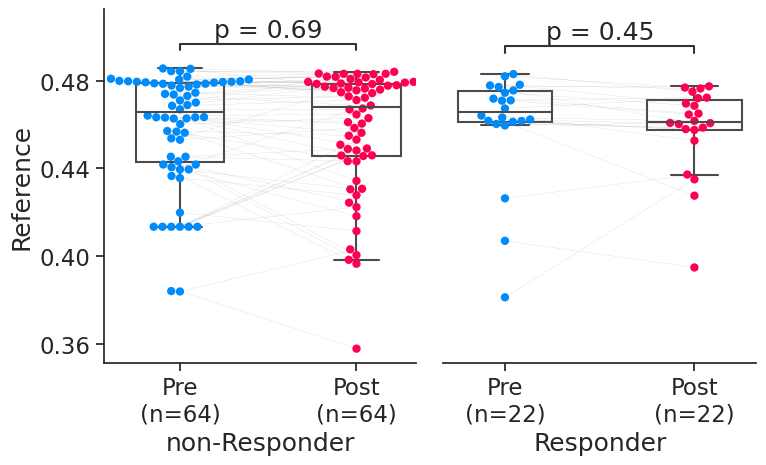

In [54]:
# for c, ax in zip(['Cytotoxic_Tcell', 'Exhausted_Tcell', 'Reference' ], axes): #Exhausted_Tcell

c = 'Reference'
df1 = dfe1[[c]] #,'Cytotoxic_Tcell' Exhausted_Tcell
df1['group'] = 'Pre'
df1['response_label'] = df_label1.response_label
#df1['patient_id'] = df_label1.patient_id

df1['patient_id'] = df_label1['patient_id'] + '@' + df_label1.reset_index().index.astype(str)



df2 = dfe2[[c]]
df2['group'] = 'Post'  
df2['response_label'] = df_label2.response_label
#df2['patient_id'] = df_label2.patient_id

df2['patient_id'] = df_label2['patient_id'] + '@' + df_label2.reset_index().index.astype(str)

df = df1._append(df2)

x = 'group'
dfp = df

dfx = pd.pivot_table(data =dfp, values = c, index = ['patient_id', 'response_label'], columns = 'group')
dfx = dfx.reset_index()

data_long = dfx.melt(id_vars=[ 'patient_id', 'response_label'], 
                      value_vars=['Pre', 'Post'], 
                      var_name='Timepoint', 
                      value_name=c)

fig, ax = plt.subplots(figsize=(8, 5),  sharey=True)

x = 'Timepoint'
hue = 'response_label'


sns.boxplot(data = data_long, x = x, hue = hue, y = c, ax=ax, fliersize=0, dodge=True,
                palette = palette,  saturation=1) #boxprops={'facecolor':'None'},

sns.stripplot(data = data_long, x = x, y = c, hue = hue,  zorder = 0.5,size=3, linewidth = 0.01,dodge = True,
            ax=ax, palette = palette, legend=False) #palette = palette, boxprops={'facecolor':'None'}

pairs = [(('Pre', 'R'), ('Pre','NR')), (('Post', 'R'), ('Post','NR'))]

annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, hue = 'response_label')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name = False,)
annotator.apply_and_annotate()


pairs = [('Pre', 'Post')]
annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c, )
annotator.configure(test='t-test_paired', text_format='simple', loc='outside', show_test_name = False,)
annotator.apply_and_annotate()


########################################################
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

for ax, group in zip(axes, ['NR', 'R']):

    data = dfx[dfx['response_label'] == group]

    n = len(data)
    
    columns = {'Post':'Post\n(n=%s)' % n, 'Pre':'Pre\n(n=%s)' % n}
    data = data.rename(columns = columns)
    
    order = ['Pre\n(n=%s)' % n, 'Post\n(n=%s)' % n]
    
    
    data_long = data.melt(id_vars=[ 'patient_id', 'response_label'], 
                          value_vars=order, 
                          var_name='Timepoint', 
                          value_name=c)
    

    if group == 'R':
        color = c2
    else:
        color = c1
    # Plot lines connecting pre and post values
    
    # Plot lines connecting individual pre and post values
    bd = 0
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id]
        x = [0, 1]
        y = [patient_data[order[0]].values[0], patient_data[order[1]].values[0]]
        color = 'grey' if y[1] < y[0] else 'grey'
        ax.plot(x, y, marker=None, color=color, lw = .1, ls = '--'  )
        if  y[1] < y[0]:
            print(patient_id, y[0]-y[1])
            #ax.text(0, y[0], patient_id.split('@')[0] , color = color, fontsize=10)
            bd += 1
    
    text = '%s/%s=%.1f%%' % (n-bd, n, ((n-bd)/n) * 100)
    
    sns.boxplot(x='Timepoint', y=c, data=data_long, ax=ax,width = .5, fliersize=0,
                palette = palette,  saturation= 1, linewidth = None, boxprops={'facecolor':'None'}) #boxprops={'facecolor':'None'},boxprops={'facecolor':'None'}
    
    sns.swarmplot(data = data_long, x = 'Timepoint', y = c, zorder = 2,size=6,linewidth = 0.00,
                ax=ax, palette = palette) #palette = palette, boxprops={'facecolor':'None'}

    
    #ax.text(0.1, data[order].max().mean(), text)
    
    # Add annotations for paired t-test
    pairs = [order]
    annotator = Annotator(ax, pairs, data=data_long, x='Timepoint', y=c)
    annotator.configure(test='t-test_paired', text_format='simple', loc='inside', show_test_name = False,)
    annotator.apply_and_annotate()
    
    #ax.tick_params(axis='both', which='major', labelsize=18)
    
    # 设置坐标轴名字字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    
    if group != 'R':
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    else:
         ax.spines['left'].set_visible(False)
         ax.set_ylabel(None)
         ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xlabel({'NR':'non-Responder', 'R':'Responder'}[group])
    
fig.tight_layout()

fig.savefig("./results/03_pre_post_R_NR_lineplot_%s.svg" % c  , bbox_inches = 'tight')